# Solutions to DSI Regularized Regression Pair Assignment

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone

%matplotlib inline
import matplotlib.pyplot as plt

from utils import XyScaler

/Users/matthewdrury/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


## Part 1: Loading the Diabetes Data

### 1. Load the diabetes data from sklearn using the instructions in the [sklearn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html).


In [2]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()

We need to figure out how to use this `diabetes` object we got back, so let's look at what attributes it has.

Looks like 
  - `data` is going to contain be our predictors.
  - `feature_names` has the human readable names of the features.
  - `target` is going to contain our response.
  
Let's put this all into a more reasonable data structure, we can combine `data` and `feature_names` into a data frame.

### 2. Some of the work at the end of this assignment will be very computationally heavy, so we will subset our data to make this work more approachable.  Take the first 100 rows from the diabetes data and target to use as your raw data in this assignment.

In [3]:
X_raw = diabetes.data[:100]
y_raw = diabetes.target[:100]

X = pd.DataFrame(X_raw, columns=diabetes.feature_names)
y = pd.Series(y_raw, index=X.index)

### 3. Take an initial look at the data, and investigate what the predictors mean.  You may have to do some detective work with google.

In [4]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


Some interesting things going on here.

Four of the predictors have human interpretable names.  An almost sure guess is that `bmi` is body mass index, and `bp` is blood pressure.
  
We can confirm this with a quick google search, which reveals [this](http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html) page of documentation.

The documentation also reveals what the mysterious `s1, s2, ...` predictors are.
  
>  six blood serum measurements...
  
That doesn't mean much without some domain knowledge, but at least we have some awareness of what's going on.

Finally, the values in this data frame are interesting.  In particular, `age` should take positive integer values, but doesn't, and `sex` should be a boolean, but is not.  Checking out the unique values of `sex` is revealing:

In [5]:
np.unique(X['sex'])

array([-0.04464164,  0.05068012])

There are two unique values.  One must indicate males and one must indicate females.

A guess at what's going on here is that the data has been normalized in some way.  We can check this informally by calculating the mean of all our features.

In [6]:
X.mean()

age   -0.009801
sex   -0.004606
bmi   -0.010539
bp    -0.011294
s1    -0.011324
s2    -0.012039
s3     0.009762
s4    -0.013991
s5    -0.010764
s6    -0.012758
dtype: float64

Yup, all the means are zero.

A little poking at the documentation confirms

> Each of these 10 feature variables have been mean centered and scaled by the standard deviation times n_samples (i.e. the sum of squares of each column totals 1).

That's a weird sort of normalization, so is not so useful for us.  But it's good to know what's going on here.

Let's now poke at the target, we don't yet even know if this is a regression or classification problem.

In [7]:
y.head()

0    151.0
1     75.0
2    141.0
3    206.0
4    135.0
dtype: float64

Looks like a regression problem.

Checking the documentation confirms:

> **Target**:	Column 11 is a quantitative measure of disease progression one year after baseline

### 4. Do some basic EDA.  Check for missing values, plot the univariate and joint distributions of the predictors and target.

Let's take a look at the structure of our data, and how it relates to the response.

To use `scatter_matrix` we need to add `y` as a column in our data frame.

In [8]:
diabetes_full = X.copy()
diabetes_full['disease_progression'] = y

In [9]:
diabetes_full.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease_progression
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


### Check for Missing Vales

As an initial check, we should make check our full data set for missing values.

In [10]:
diabetes_full.isnull().sum()

age                    0
sex                    0
bmi                    0
bp                     0
s1                     0
s2                     0
s3                     0
s4                     0
s5                     0
s6                     0
disease_progression    0
dtype: int64

Ok, looks like there are none, so we don't have to worry about this for the time being.

### Plots

Before we begin any EDA, we better hold out our final test set.  Otherwise we will be implicitly learning about our test set through EDA.

In [11]:
diabetes_train, diabetes_test = train_test_split(diabetes_full, test_size=1/3)
diabetes_train = diabetes_train.copy()
diabetes_test = diabetes_test.copy()

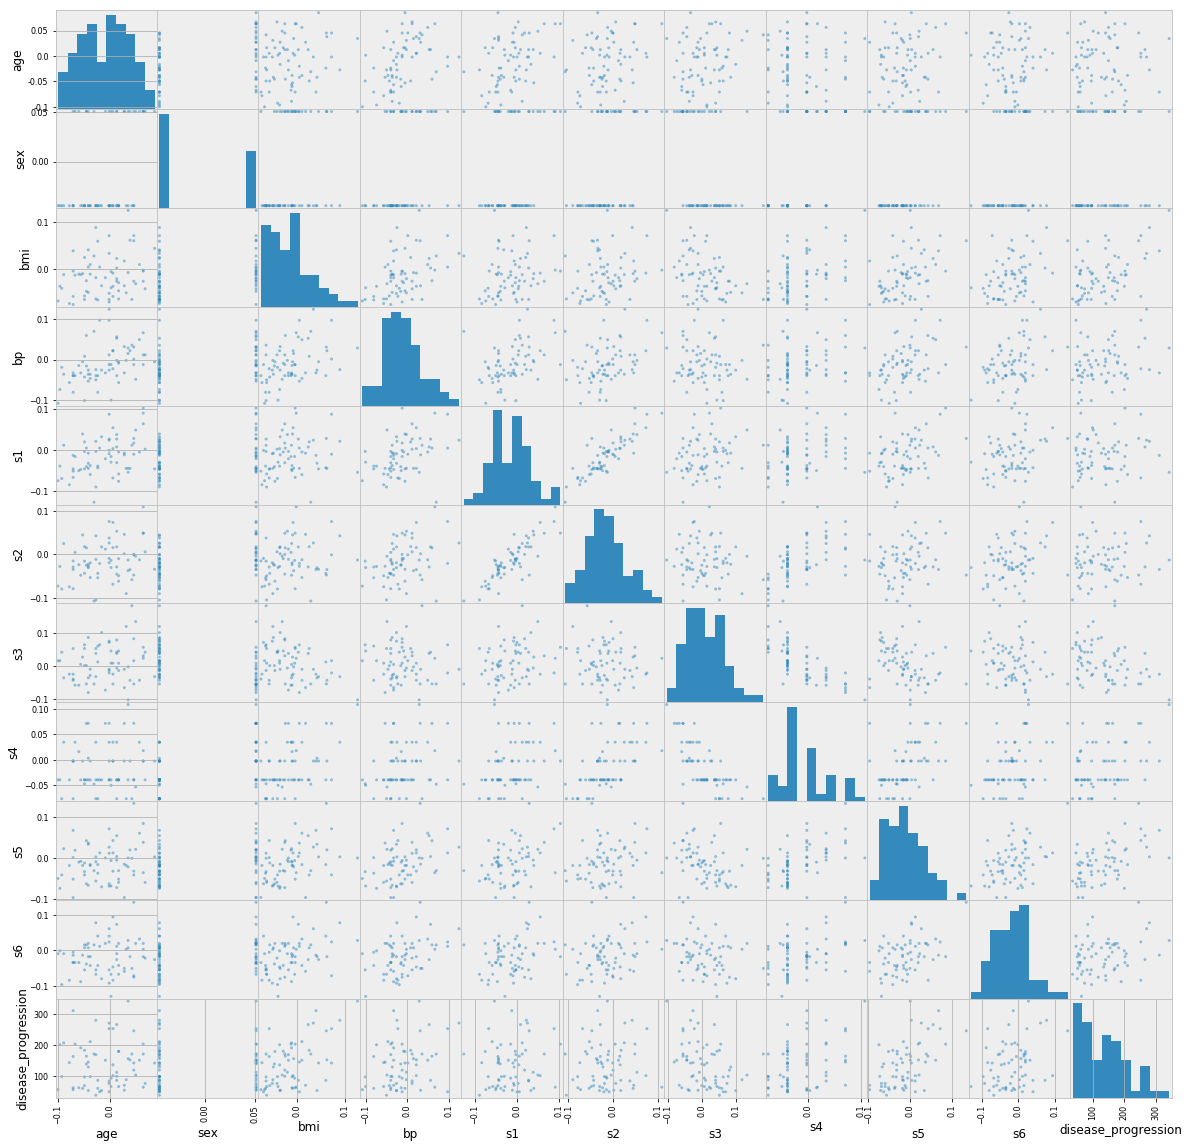

In [12]:
_ = scatter_matrix(diabetes_train, figsize=(20, 20))

Some interesting observations about our data emerge.

  - There seem to be some decent predictors.  `bmi` and `bp` have a good correlation with the target, as do some of the serum measurements.
  - There are some strong correlations within the predictors themselves, the strongest being between the first two serum measurements, and the most concerning being the `bmi` and `bp` measurements.  This will not cause problems for prediction, but we will need to make note of this if we wish to interpret the parameter estimates from our model in any way.
  
We should take a look at the distribution of the response, just to make sure that treating this as just a regression problem is completely sensible.

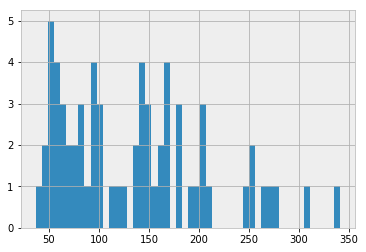

In [13]:
fig, ax = plt.subplots()

_ = ax.hist(diabetes_train['disease_progression'], bins=50)

There's nothing much of concern here.  We should be good to go using a single regression model.

## Part 2: Ridge Regression

### 1. Split your data into a training and testing set.  The training set will be used to fit and tune all your models, and the testing set will be used only at the very end to compare final models.

In [14]:
target_column = "disease_progression"
X_train, y_train = diabetes_train.drop(target_column, axis=1), diabetes_train[target_column]
X_test, y_test = diabetes_test.drop(target_column, axis=1), diabetes_test[target_column]

### 2. Let's fit a model just to get the mechanics of using `Ridge` down.  Fit a ridge regression with `alpha = 0.5` to your training dataset.  Use the fit model to generate predictions on your testing dataset.  Calculate the MSE of your fit model on the test set.

We're really just doing this to make sure that we don't have any issues in our data that will break our model fitting.

In [15]:
ridge = Ridge(alpha=0.5)
ridge.fit(X_train, y_train)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [16]:
def rss(y, y_hat):
    return np.mean((y  - y_hat)**2)

In [17]:
preds = ridge.predict(X_test)
mse = rss(y_test, preds)
print("MSE for Ridge(alpha=0.5): {:2.2f}".format(mse))

MSE for Ridge(alpha=0.5): 3173.26


Look's like fit worked well, so we are good to go.

### 3. Estimate the out of sample error of your ridge regression using 10-fold cross validation.  Remember that your predictors and response **must** be standardized when using ridge regression, and that this standardization must happen **inside** of the cross validation using **only** the training set!

...and...

### 4. Wrap your cross validation code from above into a function:

In [18]:
def cv(X, y, base_estimator, n_folds, random_seed=154):
    """Estimate the in and out-of-sample error of a model using cross validation.
    
    Parameters
    ----------
    
    X: np.array
      Matrix of predictors.
      
    y: np.array
      Target array.
      
    base_estimator: sklearn model object.
      The estimator to fit.  Must have fit and predict methods.
      
    n_folds: int
      The number of folds in the cross validation.
      
    random_seed: int
      A seed for the random number generator, for repeatability.
    
    Returns
    -------
      
    train_cv_errors, test_cv_errors: tuple of arrays
      The training and testing errors for each fold of cross validation.
    """
    kf = KFold(n_splits=n_folds, random_state=random_seed)
    test_cv_errors, train_cv_errors = np.empty(n_folds), np.empty(n_folds)
    for idx, (train, test) in enumerate(kf.split(X_train)):
        # Split into train and test
        X_cv_train, y_cv_train = X[train], y[train]
        X_cv_test, y_cv_test = X[test], y[test]
        # Standardize data.
        standardizer = XyScaler()
        standardizer.fit(X_cv_train, y_cv_train)
        X_cv_train_std, y_cv_train_std = standardizer.transform(X_cv_train, y_cv_train)
        X_cv_test_std, y_cv_test_std = standardizer.transform(X_cv_test, y_cv_test)
        # Fit estimator
        estimator = clone(base_estimator)
        estimator.fit(X_cv_train_std, y_cv_train_std)
        # Measure performance
        y_hat_train = estimator.predict(X_cv_train_std)
        y_hat_test = estimator.predict(X_cv_test_std)
        # Calclate the error metrics
        train_cv_errors[idx] = rss(y_cv_train_std, y_hat_train)
        test_cv_errors[idx] = rss(y_cv_test_std, y_hat_test)
    return train_cv_errors, test_cv_errors

In [19]:
n_folds = 10
train_cv_errors, test_cv_errors = cv(X_train.values, y_train.values, 
                                     Ridge(alpha=0.5), n_folds=n_folds)

Now we have arrays of our errors on different folds, and our final CV estimates of the error are the means of these arrays.

In [20]:
print("Training CV error: {:2.2f}".format(train_cv_errors.mean()))
print("Test CV error: {:2.2f}".format(test_cv_errors.mean()))

Training CV error: 0.52
Test CV error: 0.87


The training error is lower than the testing error, which is what we should expect.

### 5. Vary the values of alpha starting at zero. Compute the training and testing errors for each value of alpha using ten-fold cross validation.

With our `cv` function from above, this is pretty easy.

In [21]:
def train_at_various_alphas(X, y, model, alphas, n_folds=10, **kwargs):
    """Train a regularized regression model using cross validation at various values of alpha.
    
    Parameters
    ----------
    
    X: np.array
      Matrix of predictors.
      
    y: np.array
      Target array.
      
    model: sklearn model class
      A class in sklearn that can be used to create a regularized regression object.  Options are `Ridge` and `Lasso`.
      
    alphas: numpy array
      An array of regularization parameters.
      
    n_folds: int
      Number of cross validation folds.
      
    Returns
    -------
    
    cv_errors_train, cv_errors_test: tuple of DataFrame
      DataFrames containing the training and testing errors for each value of 
      alpha and each cross validation fold.  Each row represents a CV fold,
      and each column a value of alpha.
    """
    cv_errors_train = pd.DataFrame(np.empty(shape=(n_folds, len(alphas))),
                                     columns=alphas)
    cv_errors_test = pd.DataFrame(np.empty(shape=(n_folds, len(alphas))),
                                        columns=alphas)
    for alpha in alphas:
        train_fold_errors, test_fold_errors = cv(X, y, model(alpha=alpha, **kwargs), n_folds=n_folds)
        cv_errors_train.loc[:, alpha] = train_fold_errors
        cv_errors_test.loc[:, alpha] = test_fold_errors
    return cv_errors_train, cv_errors_test

In [22]:
ridge_alphas = np.logspace(-2, 4, num=250)

ridge_cv_errors_train, ridge_cv_errors_test = train_at_various_alphas(
    X_train.values, y_train.values, Ridge, ridge_alphas)

In [23]:
ridge_cv_errors_train.head()

,0.01,0.01057052081,0.0111735910195,0.0118110676394,0.0124849136271,0.0131972039306,0.0139501318782,0.0147460159321,0.0155873068275,0.0164765951193,...,6069.21510641,6415.47645827,6781.49274083,7168.39101399,7577.36263877,8009.66694581,8466.63511319,8949.67426547,9460.2718066,10000.0
0,0.553144,0.553144,0.553144,0.553144,0.553144,0.553144,0.553144,0.553144,0.553144,0.553145,...,0.977982,0.979112,0.980187,0.981210,0.982181,0.983105,0.983983,0.984816,0.985608,0.986360
1,0.530065,0.530065,0.530065,0.530065,0.530065,0.530065,0.530065,0.530065,0.530065,0.530065,...,0.981778,0.982721,0.983617,0.984468,0.985276,0.986044,0.986774,0.987466,0.988123,0.988747
2,0.500569,0.500569,0.500569,0.500569,0.500569,0.500569,0.500569,0.500569,0.500569,0.500569,...,0.981382,0.982348,0.983266,0.984138,0.984966,0.985753,0.986499,0.987207,0.987880,0.988518
3,0.550207,0.550207,0.550208,0.550208,0.550208,0.550208,0.550208,0.550208,0.550208,0.550208,...,0.979841,0.980881,0.981870,0.982810,0.983703,0.984552,0.985357,0.986122,0.986849,0.987538
4,0.520826,0.520826,0.520826,0.520826,0.520826,0.520826,0.520826,0.520826,0.520826,0.520826,...,0.979091,0.980171,0.981198,0.982173,0.983100,0.983980,0.984816,0.985610,0.986363,0.987079


In [24]:
ridge_cv_errors_test.head()

,0.01,0.01057052081,0.0111735910195,0.0118110676394,0.0124849136271,0.0131972039306,0.0139501318782,0.0147460159321,0.0155873068275,0.0164765951193,...,6069.21510641,6415.47645827,6781.49274083,7168.39101399,7577.36263877,8009.66694581,8466.63511319,8949.67426547,9460.2718066,10000.0
0,0.637284,0.637263,0.637240,0.637216,0.637191,0.637165,0.637137,0.637107,0.637076,0.637043,...,1.272841,1.273290,1.273716,1.274120,1.274503,1.274866,1.275209,1.275535,1.275844,1.276136
1,0.667044,0.667046,0.667048,0.667049,0.667051,0.667053,0.667055,0.667058,0.667060,0.667062,...,1.150925,1.152036,1.153092,1.154095,1.155047,1.155951,1.156809,1.157624,1.158397,1.159130
2,0.762064,0.762059,0.762055,0.762050,0.762045,0.762039,0.762034,0.762028,0.762021,0.762014,...,0.658614,0.659450,0.660246,0.661003,0.661723,0.662407,0.663058,0.663676,0.664263,0.664821
3,0.162864,0.162873,0.162882,0.162891,0.162901,0.162911,0.162922,0.162934,0.162946,0.162959,...,0.578364,0.578770,0.579156,0.579524,0.579873,0.580204,0.580519,0.580819,0.581103,0.581372
4,0.435028,0.435033,0.435039,0.435044,0.435050,0.435056,0.435063,0.435070,0.435077,0.435085,...,0.636126,0.636398,0.636658,0.636905,0.637140,0.637364,0.637577,0.637779,0.637972,0.638155


### 6. Average your ten estimates of training and testing error for each alpha to get a more stable estimate of the training and testing error for each value of the regularization parameter. Plot the average training and testing MSE curves as alpha varies (the plot will look better if you use log(\alpha) on the horizontal axis).  

...and...

### 7. Compute the value of alpha that leads to the minimum CV test error, and superimpose a vertical line at the optimal value of alpha onto your plot of the MSE curves.

In [25]:
ridge_mean_cv_errors_train = ridge_cv_errors_train.mean(axis=0)
ridge_mean_cv_errors_test = ridge_cv_errors_test.mean(axis=0)

In [26]:
def get_optimal_alpha(mean_cv_errors_test):
    alphas = mean_cv_errors_test.index
    optimal_idx = np.argmin(mean_cv_errors_test.values)
    optimal_alpha = alphas[optimal_idx]
    return optimal_alpha

ridge_optimal_alpha = get_optimal_alpha(ridge_mean_cv_errors_test)

Text(0,0.5,'MSE')

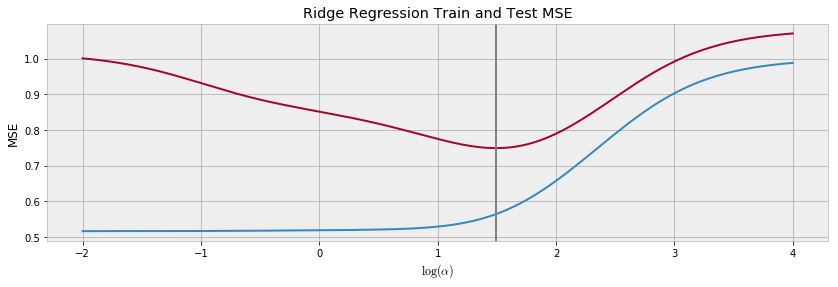

In [27]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(np.log10(ridge_alphas), ridge_mean_cv_errors_train)
ax.plot(np.log10(ridge_alphas), ridge_mean_cv_errors_test)
ax.axvline(np.log10(ridge_optimal_alpha), color='grey')
ax.set_title("Ridge Regression Train and Test MSE")
ax.set_xlabel(r"$\log(\alpha)$")
ax.set_ylabel("MSE")

### 8. Fit a sequence of ridge regression models to the full training data for the same sequence of alpha's as above, then plot the coefficient paths as a function of log(alpha).  Superimpose a vertical line at the optimal value of alpha as chosen by cross validation.

First, let's build up an array of fit models.

In [28]:
ridge_models = []

for alpha in ridge_alphas:
    scaler = XyScaler()
    scaler.fit(X_train.values, y_train.values)
    X_train_std, y_train_std = scaler.transform(X_train.values, y_train.values)
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_std, y_train_std)
    ridge_models.append(ridge)

Now, let's create a matrix of coefficient paths.  To keep track of the names, we will make a data frame where each column is a predictor, and each row is a value of $\alpha$.

In [29]:
paths = pd.DataFrame(np.empty(shape=(len(ridge_alphas), len(X_train.columns))),
                     index=ridge_alphas, columns=X_train.columns)

for idx, model in enumerate(ridge_models):
    paths.iloc[idx] = model.coef_

Text(0,0.5,'Standardized Coefficient')

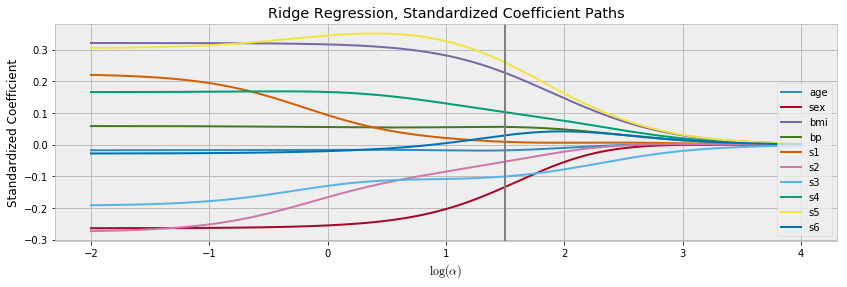

In [30]:
fig, ax = plt.subplots(figsize=(14, 4))

for column in X_train.columns:
    path = paths.loc[:, column]
    ax.plot(np.log10(ridge_alphas), path, label=column)
ax.axvline(np.log10(ridge_optimal_alpha), color='grey')
ax.legend(loc='lower right')
ax.set_title("Ridge Regression, Standardized Coefficient Paths")
ax.set_xlabel(r"$\log(\alpha)$")
ax.set_ylabel("Standardized Coefficient")

## Part 2: LASSO Regression

In [34]:
lasso_alphas = np.logspace(-3, 1, num=250)

lasso_cv_errors_train, lasso_cv_errors_test = train_at_various_alphas(
    X_train.values, y_train.values, Lasso, lasso_alphas, max_iter=5000)

In [35]:
lasso_cv_errors_test.shape

(10, 250)

Text(0,0.5,'MSE')

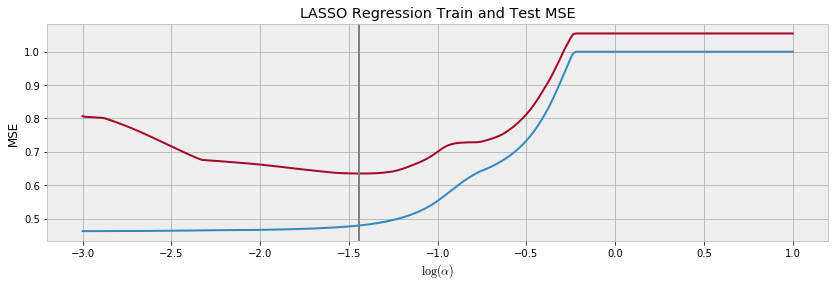

In [55]:
lasso_mean_cv_errors_train = lasso_cv_errors_train.mean(axis=0)
lasso_mean_cv_errors_test = lasso_cv_errors_test.mean(axis=0)

lasso_optimal_alpha = get_optimal_alpha(lasso_mean_cv_errors_test)
    
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(np.log10(lasso_alphas), lasso_mean_cv_errors_train)
ax.plot(np.log10(lasso_alphas), lasso_mean_cv_errors_test)
ax.axvline(np.log10(lasso_optimal_alpha), color='grey')
ax.set_title("LASSO Regression Train and Test MSE")
ax.set_xlabel(r"$\log(\alpha)$")
ax.set_ylabel("MSE")

In [38]:
lasso_models = []

for alpha in lasso_alphas:
    scaler = XyScaler()
    scaler.fit(X_train.values, y_train.values)
    X_train_std, y_train_std = scaler.transform(X_train.values, y_train.values)
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_std, y_train_std)
    lasso_models.append(lasso)

Text(0,0.5,'Standardized Coefficient')

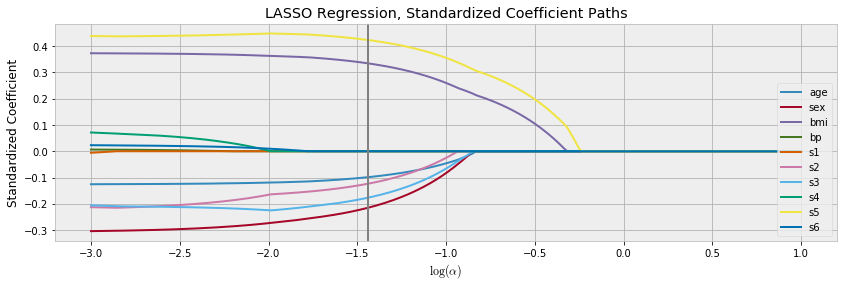

In [57]:
paths = pd.DataFrame(np.empty(shape=(len(lasso_alphas), len(X_train.columns))),
                     index=lasso_alphas, columns=X_train.columns)

for idx, model in enumerate(lasso_models):
    paths.iloc[idx] = model.coef_
    
fig, ax = plt.subplots(figsize=(14, 4))
for column in X_train.columns:
    path = paths.loc[:, column]
    ax.plot(np.log10(lasso_alphas), path, label=column)
ax.axvline(np.log10(lasso_optimal_alpha), color='grey')
ax.legend(loc='lower right')
ax.set_title("LASSO Regression, Standardized Coefficient Paths")
ax.set_xlabel(r"$\log(\alpha)$")
ax.set_ylabel("Standardized Coefficient")

## 3. Model Comparison

In [40]:
standardizer = XyScaler()
standardizer.fit(X_train.values, y_train.values)
X_train_std, y_train_std = standardizer.transform(X_train.values, y_train.values)
X_test_std, y_test_std = standardizer.transform(X_test.values, y_test.values)

In [41]:
final_ridge = Ridge(alpha=ridge_optimal_alpha).fit(X_train_std, y_train_std)
final_lasso = Lasso(alpha=lasso_optimal_alpha).fit(X_train_std, y_train_std)
final_lr = LinearRegression().fit(X_train_std, y_train_std)

In [42]:
final_ridge_rss = rss(y_test_std, final_ridge.predict(X_test_std))
final_lasso_rss = rss(y_test_std, final_lasso.predict(X_test_std))
final_lr_rss = rss(y_test_std, final_lr.predict(X_test_std))

In [43]:
print("Final Ridge RSS: {:2.3f}".format(final_ridge_rss))
print("Final Lasso RSS: {:2.3f}".format(final_lasso_rss))
print("Final Linear Regression RSS: {:2.3f}".format(final_lr_rss))

Final Ridge RSS: 0.937
Final Lasso RSS: 0.925
Final Linear Regression RSS: 0.999


## Extra

In [44]:
from sklearn.utils import resample

def booststrap_cv(X, y, model, alphas, n_bootstraps=1000, n_folds=10, **kwargs):
    test_errors = np.empty(n_bootstraps)
    for idx in range(n_bootstraps):
        X_boot, y_boot = resample(X, y)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.33)
        _, cv_errors_test = train_at_various_alphas(
            X, y, model, alphas, n_folds=n_folds, **kwargs)
        mean_cv_errors_test = cv_errors_test.mean(axis=0)
        optimal_alpha = get_optimal_alpha(mean_cv_errors_test)
        # Re-train model at optimal alpha
        standardizer = XyScaler()
        standardizer.fit(X_train, y_train)
        X_train_std, y_train_std = standardizer.transform(X_train, y_train,)
        X_test_std, y_test_std = standardizer.transform(X_test, y_test)
        final_fit_model = model(alpha=optimal_alpha).fit(X_train_std, y_train_std)
        final_rss = rss(y_test_std, final_fit_model.predict(X_test_std))
        test_errors[idx] = final_rss    
    return test_errors

In [45]:
ridge_bootstrapped_test_errors = booststrap_cv(
    X.values, y.values, Ridge, ridge_alphas)

In [46]:
lasso_bootstrapped_test_errors = booststrap_cv(
    X.values, y.values, Lasso, lasso_alphas, max_iter=5000)

In [47]:
ridge_mean_bootrapped_test_error = np.mean(
    ridge_bootstrapped_test_errors)
lasso_mean_bootrapped_test_error = np.mean(
    lasso_bootstrapped_test_errors)

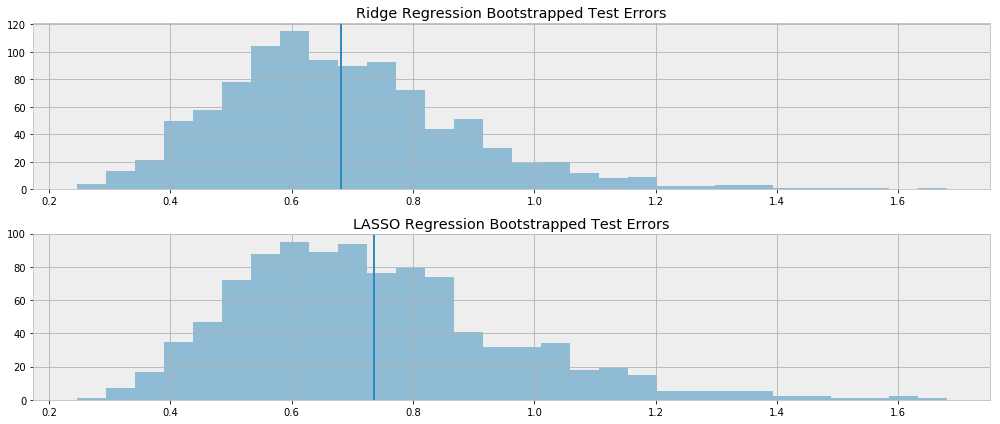

In [48]:
fig, axs = plt.subplots(2, figsize=(14, 6))

_, bins, _ = axs[0].hist(ridge_bootstrapped_test_errors, bins=30, alpha=0.5)
axs[0].axvline(ridge_mean_bootrapped_test_error)
axs[0].set_title("Ridge Regression Bootstrapped Test Errors")

axs[1].hist(lasso_bootstrapped_test_errors, bins=bins, alpha=0.5)
axs[1].axvline(lasso_mean_bootrapped_test_error)
axs[1].set_title("LASSO Regression Bootstrapped Test Errors")

fig.tight_layout()

In [50]:
def bootstrap_lm(X, y, n_bootstraps=1000, n_folds=10, **kwargs):
    test_errors = np.empty(n_bootstraps)
    for idx in range(n_bootstraps):
        X_boot, y_boot = resample(X, y)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.33)
        standardizer = XyScaler()
        standardizer.fit(X_train, y_train)
        X_train_std, y_train_std = standardizer.transform(X_train, y_train,)
        X_test_std, y_test_std = standardizer.transform(X_test, y_test)
        lm = LinearRegression().fit(X_train_std, y_train_std)
        final_rss = rss(y_test_std, lm.predict(X_test_std))
        test_errors[idx] = final_rss    
    return test_errors

lm_bootstrapped_test_errors = bootstrap_lm(X.values, y.values)
lm_mean_bootrapped_test_error = np.mean(lm_bootstrapped_test_errors)

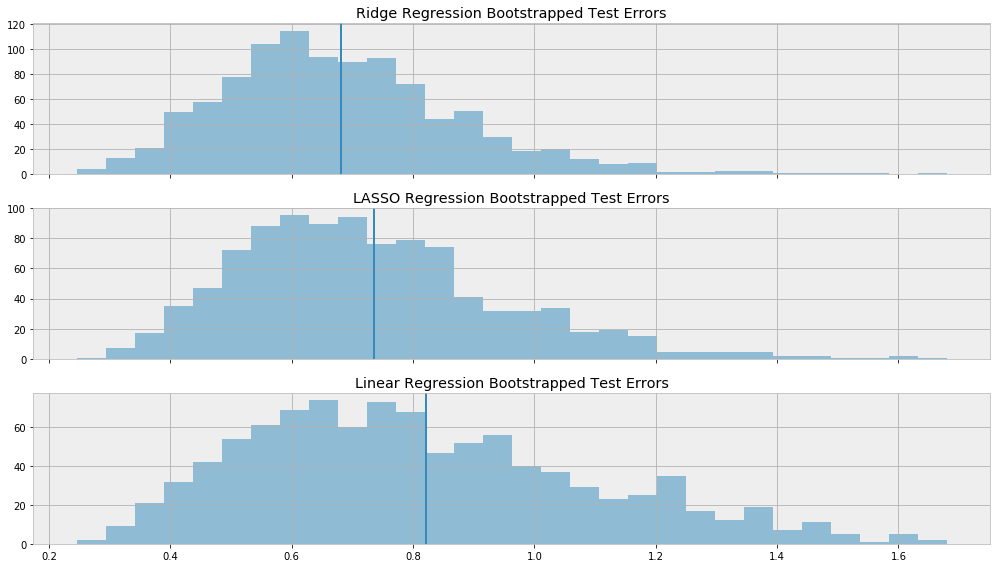

In [51]:
fig, axs = plt.subplots(3, figsize=(14, 8), sharex=True)

_, bins, _ = axs[0].hist(ridge_bootstrapped_test_errors, bins=30, alpha=0.5)
axs[0].axvline(ridge_mean_bootrapped_test_error)
axs[0].set_title("Ridge Regression Bootstrapped Test Errors")

axs[1].hist(lasso_bootstrapped_test_errors, bins=bins, alpha=0.5)
axs[1].axvline(lasso_mean_bootrapped_test_error)
axs[1].set_title("LASSO Regression Bootstrapped Test Errors")

axs[2].hist(lm_bootstrapped_test_errors, bins=bins, alpha=0.5)
axs[2].axvline(lm_mean_bootrapped_test_error)
axs[2].set_title("Linear Regression Bootstrapped Test Errors")

fig.tight_layout()

Looks like Ridge regression is our best choice for this data set.  This is our *final* choice.  Now all that is left is to refit the process on the full data set (train and test together) and deliver our final model.